In [13]:
import torchvision
from pathlib import Path
import torch

from torch import nn
from scripts import data_setup, engine, utils, helper_functions
import torchinfo

In [14]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data_path = Path("data/")
image_path = data_path / "soil_images_sorted"

In [16]:
#HyperParameters
batch_Size = 3
learning_rate = 0.0001
epochS = 20
dropout_prob = 0.5

In [17]:
# Get a set of pretrained model weights
weights = torchvision.models.DenseNet201_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [18]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [19]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1b9c2934e30>,
 ['high', 'low', 'medium'])

In [20]:
model = torchvision.models.densenet201(weights=weights).to(device)

In [21]:
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.features.parameters():
#     param.requires_grad = False

In [22]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=1920, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [23]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
torchinfo.summary(model, 
        input_size=(3, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [3, 3, 224, 224]     [3, 3]               --                   True
├─Sequential (features)                       [3, 3, 224, 224]     [3, 1920, 7, 7]      --                   True
│    └─Conv2d (conv0)                         [3, 3, 224, 224]     [3, 64, 112, 112]    9,408                True
│    └─BatchNorm2d (norm0)                    [3, 64, 112, 112]    [3, 64, 112, 112]    128                  True
│    └─ReLU (relu0)                           [3, 64, 112, 112]    [3, 64, 112, 112]    --                   --
│    └─MaxPool2d (pool0)                      [3, 64, 112, 112]    [3, 64, 56, 56]      --                   --
│    └─_DenseBlock (denseblock1)              [3, 64, 56, 56]      [3, 256, 56, 56]     --                   True
│    │    └─_DenseLayer (denselayer1)         [3, 64, 56, 56]      [3, 32, 56, 56]     

In [24]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:34<10:56, 34.58s/it]

Epoch: 1 | train_loss: 0.8271 | train_acc: 0.6190 | test_loss: 0.4305 | test_acc: 0.8333


 10%|█         | 2/20 [01:08<10:11, 33.96s/it]

Epoch: 2 | train_loss: 0.5526 | train_acc: 0.7768 | test_loss: 0.3561 | test_acc: 0.8333


 15%|█▌        | 3/20 [01:40<09:26, 33.34s/it]

Epoch: 3 | train_loss: 0.4793 | train_acc: 0.8125 | test_loss: 0.2363 | test_acc: 0.9111


 20%|██        | 4/20 [02:14<08:54, 33.44s/it]

Epoch: 4 | train_loss: 0.4491 | train_acc: 0.8423 | test_loss: 0.1653 | test_acc: 0.9556


 25%|██▌       | 5/20 [02:48<08:24, 33.62s/it]

Epoch: 5 | train_loss: 0.3949 | train_acc: 0.8750 | test_loss: 0.1259 | test_acc: 0.9556


 30%|███       | 6/20 [03:23<08:00, 34.31s/it]

Epoch: 6 | train_loss: 0.2790 | train_acc: 0.9018 | test_loss: 0.2259 | test_acc: 0.8889


 35%|███▌      | 7/20 [03:55<07:13, 33.36s/it]

Epoch: 7 | train_loss: 0.2338 | train_acc: 0.9048 | test_loss: 0.1417 | test_acc: 0.9556


 40%|████      | 8/20 [04:29<06:41, 33.48s/it]

Epoch: 8 | train_loss: 0.1847 | train_acc: 0.9315 | test_loss: 0.1892 | test_acc: 0.9333


 45%|████▌     | 9/20 [05:00<06:00, 32.76s/it]

Epoch: 9 | train_loss: 0.2848 | train_acc: 0.8929 | test_loss: 0.1266 | test_acc: 0.9556


 50%|█████     | 10/20 [05:32<05:25, 32.59s/it]

Epoch: 10 | train_loss: 0.2822 | train_acc: 0.9077 | test_loss: 0.1431 | test_acc: 1.0000


 55%|█████▌    | 11/20 [06:03<04:50, 32.28s/it]

Epoch: 11 | train_loss: 0.2409 | train_acc: 0.9167 | test_loss: 0.2246 | test_acc: 0.9111


 60%|██████    | 12/20 [06:37<04:20, 32.54s/it]

Epoch: 12 | train_loss: 0.2820 | train_acc: 0.9018 | test_loss: 0.3063 | test_acc: 0.8667


 65%|██████▌   | 13/20 [07:09<03:48, 32.61s/it]

Epoch: 13 | train_loss: 0.2600 | train_acc: 0.8929 | test_loss: 0.1064 | test_acc: 0.9556


 70%|███████   | 14/20 [07:42<03:16, 32.70s/it]

Epoch: 14 | train_loss: 0.2247 | train_acc: 0.9167 | test_loss: 0.0961 | test_acc: 0.9778


 75%|███████▌  | 15/20 [08:17<02:46, 33.25s/it]

Epoch: 15 | train_loss: 0.2427 | train_acc: 0.9167 | test_loss: 0.1443 | test_acc: 0.9444


 80%|████████  | 16/20 [08:49<02:12, 33.02s/it]

Epoch: 16 | train_loss: 0.2983 | train_acc: 0.8988 | test_loss: 0.1875 | test_acc: 0.9222


 85%|████████▌ | 17/20 [09:22<01:38, 32.81s/it]

Epoch: 17 | train_loss: 0.1386 | train_acc: 0.9554 | test_loss: 0.1278 | test_acc: 0.9444


 90%|█████████ | 18/20 [09:55<01:05, 33.00s/it]

Epoch: 18 | train_loss: 0.2925 | train_acc: 0.9107 | test_loss: 0.1713 | test_acc: 0.9556


 95%|█████████▌| 19/20 [10:28<00:33, 33.11s/it]

Epoch: 19 | train_loss: 0.2160 | train_acc: 0.9077 | test_loss: 0.0774 | test_acc: 0.9667


100%|██████████| 20/20 [11:01<00:00, 33.07s/it]

Epoch: 20 | train_loss: 0.2390 | train_acc: 0.9196 | test_loss: 0.0592 | test_acc: 1.0000
[INFO] Total training time: 661.466 seconds


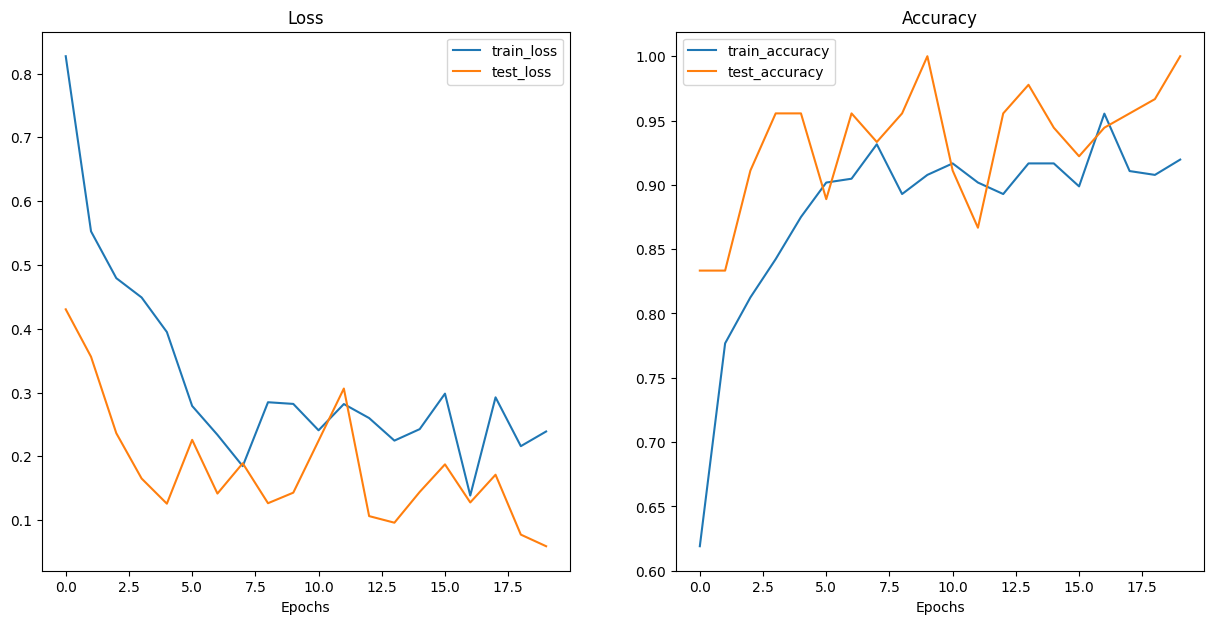

In [26]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [27]:
from winsound import Beep
Beep(300, 200)

In [28]:
utils.save_model(model=model,
                 target_dir="models",
                 model_name="densenet1.pth")

[INFO] Saving model to: models\densenet1.pth


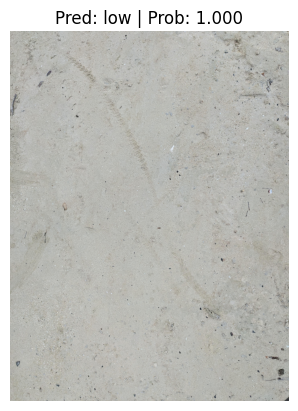

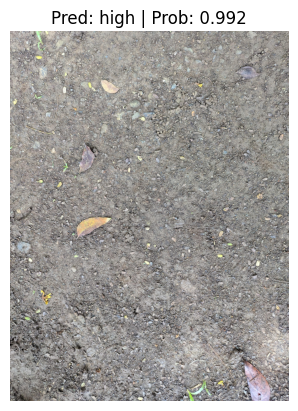

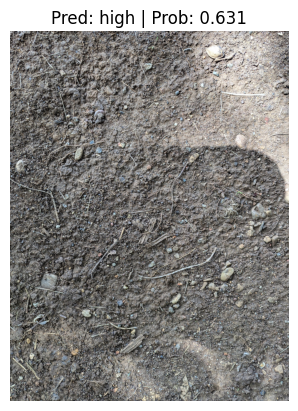

In [29]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    helper_functions.pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224),
                        device = device)